# Phase 6: Pipeline Validation

Checks:
1. Attrition by phase
2. Known ad cases
3. Consistency checks
4. Final summary

In [1]:
from IPython import display
from pathlib import Path
import yaml
import matplotlib.pyplot as plt

display.clear_output()

# Load config
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

## 1. Attrition by Phase

In [2]:
# Get image counts at each phase
phase_paths = {
    'Phase 0: Original': config['paths']['original_raw'],
    'Phase 1: Cleaned': config['paths']['cleaned_raw'],
    'Phase 2: Person Detected': config['paths']['person_only'],
    'Phase 3: Full-Body Valid': config['paths']['fullbody_filtered'],
    'Phase 4: Age Filtered': config['paths']['age_filtered'],
    'Phase 5: Final (No Ads)': config['paths']['ad_filtered']
}

# Count PNG images across subfolders

def count_images(path_obj: Path) -> int:
    return sum(1 for p in path_obj.rglob('*.png') if p.is_file())

phase_counts = {}
for phase_name, path in phase_paths.items():
    path_obj = Path(f"../{path}")
    if path_obj.exists():
        count = count_images(path_obj)
        phase_counts[phase_name] = count
    else:
        phase_counts[phase_name] = 0
        print(f"⚠️  WARNING: {phase_name} directory not found at {path}")

# Print attrition report
print("="*70)
print("PIPELINE ATTRITION REPORT")
print("="*70)

original_count = phase_counts['Phase 0: Original']

for i, (phase_name, count) in enumerate(phase_counts.items()):
    if i == 0:
        percent_remaining = 100.0
        filtered_this_phase = 0
    else:
        prev_count = list(phase_counts.values())[i-1]
        filtered_this_phase = max(prev_count - count, 0)
        percent_remaining = (count / original_count * 100) if original_count > 0 else 0
    
    print(f"\n{phase_name}")
    print(f"  Images: {count}")
    print(f"  Filtered this phase: {filtered_this_phase}")
    print(f"  Remaining: {percent_remaining:.1f}% of original")

print("\n" + "="*70)
total_filtered = original_count - phase_counts['Phase 5: Final (No Ads)']
final_retention = (phase_counts['Phase 5: Final (No Ads)'] / original_count * 100) if original_count > 0 else 0
print(f"TOTAL FILTERED: {total_filtered} images")
print(f"FINAL RETENTION: {final_retention:.1f}%")
print("="*70)

PIPELINE ATTRITION REPORT

Phase 0: Original
  Images: 1147
  Filtered this phase: 0
  Remaining: 100.0% of original

Phase 1: Cleaned
  Images: 999
  Filtered this phase: 148
  Remaining: 87.1% of original

Phase 2: Person Detected
  Images: 534
  Filtered this phase: 465
  Remaining: 46.6% of original

Phase 3: Full-Body Valid
  Images: 227
  Filtered this phase: 307
  Remaining: 19.8% of original

Phase 4: Age Filtered
  Images: 172
  Filtered this phase: 55
  Remaining: 15.0% of original

Phase 5: Final (No Ads)
  Images: 171
  Filtered this phase: 1
  Remaining: 14.9% of original

TOTAL FILTERED: 976 images
FINAL RETENTION: 14.9%


## 2. Known Ad Cases

In [3]:
# Check known ads that should be FILTERED OUT
known_ads = ['crop (63).png', 'crop (990).png']

print("\n" + "="*70)
print("KNOWN ADS TEST")
print("="*70)
print("\nVerifying that known advertisement crops are filtered out...\n")

ad_filtered_path = Path(f"../{config['paths']['ad_filtered']}")
age_filtered_path = Path(f"../{config['paths']['age_filtered']}")

ad_filtered_names = set([f.name for f in ad_filtered_path.glob('*.png')])
age_filtered_names = set([f.name for f in age_filtered_path.glob('*.png')])

for known_ad in known_ads:
    in_age_filtered = known_ad in age_filtered_names
    in_final = known_ad in ad_filtered_names
    
    if in_age_filtered and not in_final:
        print(f"✅ {known_ad}: CORRECTLY FILTERED (was in age_filtered, removed in Phase 5)")
    elif not in_age_filtered:
        print(f"⚠️  {known_ad}: Not in age_filtered (filtered out earlier)")
    elif in_final:
        print(f"❌ {known_ad}: INCORRECTLY KEPT (should have been filtered in Phase 5)")
    else:
        print(f"❓ {known_ad}: Status unknown")


KNOWN ADS TEST

Verifying that known advertisement crops are filtered out...

✅ crop (63).png: CORRECTLY FILTERED (was in age_filtered, removed in Phase 5)
❌ crop (990).png: INCORRECTLY KEPT (should have been filtered in Phase 5)


## 3. Consistency Checks

In [4]:
# Verify no images are duplicated or missing between phases
print("\n" + "="*70)
print("CONSISTENCY CHECKS")
print("="*70)

checks_passed = 0
checks_failed = 0

# Check 1: All final images exist in age_filtered
final_images = set([f.name for f in ad_filtered_path.glob('*.png')])
age_images = set([f.name for f in age_filtered_path.glob('*.png')])

print("\nCheck 1: Final images are subset of age_filtered")
if final_images.issubset(age_images):
    print(f"  ✅ PASS: All {len(final_images)} final images come from age_filtered")
    checks_passed += 1
else:
    missing = final_images - age_images
    print(f"  ❌ FAIL: {len(missing)} images in final but not in age_filtered: {list(missing)[:5]}")
    checks_failed += 1

# Check 2: No duplicates within phase
print("\nCheck 2: No duplicate images within final dataset")
final_count = len(list(ad_filtered_path.glob('*.png')))
final_unique = len(set([f.name for f in ad_filtered_path.glob('*.png')]))
if final_count == final_unique:
    print(f"  ✅ PASS: {final_count} files, all unique names")
    checks_passed += 1
else:
    print(f"  ❌ FAIL: {final_count} files but only {final_unique} unique names")
    checks_failed += 1

# Check 3: Age filtering consistency
print("\nCheck 3: Age filtering math (age_filtered - ads_detected = final)")
expected_final = len(age_images) - (len(age_images) - len(final_images))
actual_final = len(final_images)
if expected_final == actual_final:
    ads_detected = len(age_images) - len(final_images)
    print(f"  ✅ PASS: {len(age_images)} in age_filtered - {ads_detected} ads = {actual_final} final")
    checks_passed += 1
else:
    print(f"  ⚠️  Check inconsistent (expected {expected_final}, got {actual_final})")

# Check 4: Monotonic decrease (each phase ≤ previous)
print("\nCheck 4: Monotonic decrease across phases")
monotonic = True
phase_list = list(phase_counts.values())
for i in range(1, len(phase_list)):
    if phase_list[i] > phase_list[i-1]:
        monotonic = False
        print(f"  ❌ FAIL: Phase {i} ({phase_list[i]}) > Phase {i-1} ({phase_list[i-1]})")
        break

if monotonic:
    print(f"  ✅ PASS: Image counts monotonically decrease through pipeline")
    checks_passed += 1
else:
    checks_failed += 1

print("\n" + "-"*70)
print(f"Summary: {checks_passed} passed, {checks_failed} failed")
print("="*70)


CONSISTENCY CHECKS

Check 1: Final images are subset of age_filtered
  ✅ PASS: All 171 final images come from age_filtered

Check 2: No duplicate images within final dataset
  ✅ PASS: 171 files, all unique names

Check 3: Age filtering math (age_filtered - ads_detected = final)
  ✅ PASS: 172 in age_filtered - 1 ads = 171 final

Check 4: Monotonic decrease across phases
  ✅ PASS: Image counts monotonically decrease through pipeline

----------------------------------------------------------------------
Summary: 4 passed, 0 failed


## 4. Ad Report

In [5]:
# Report detected ads
print("\n" + "="*70)
print("ADVERTISEMENT DETECTION REPORT")
print("="*70)

ads_detected = len(age_images) - len(final_images)
ads_percentage = (ads_detected / len(age_images) * 100) if len(age_images) > 0 else 0

print(f"\nAge-filtered images: {len(age_images)}")
print(f"Advertisements detected: {ads_detected}")
print(f"Percentage: {ads_percentage:.2f}%")
print(f"Final clean dataset: {len(final_images)} images")

# Identify which images were filtered as ads
detected_ads = age_images - final_images

if detected_ads:
    print(f"\nDetected ads ({len(detected_ads)} total):")
    print("-"*70)
    for ad in sorted(detected_ads):
        print(f"  - {ad}")
else:
    print("\n✅ No advertisements detected in dataset")

print("="*70)


ADVERTISEMENT DETECTION REPORT

Age-filtered images: 172
Advertisements detected: 1
Percentage: 0.58%
Final clean dataset: 171 images

Detected ads (1 total):
----------------------------------------------------------------------
  - crop (63).png


## 5. Phase Charts

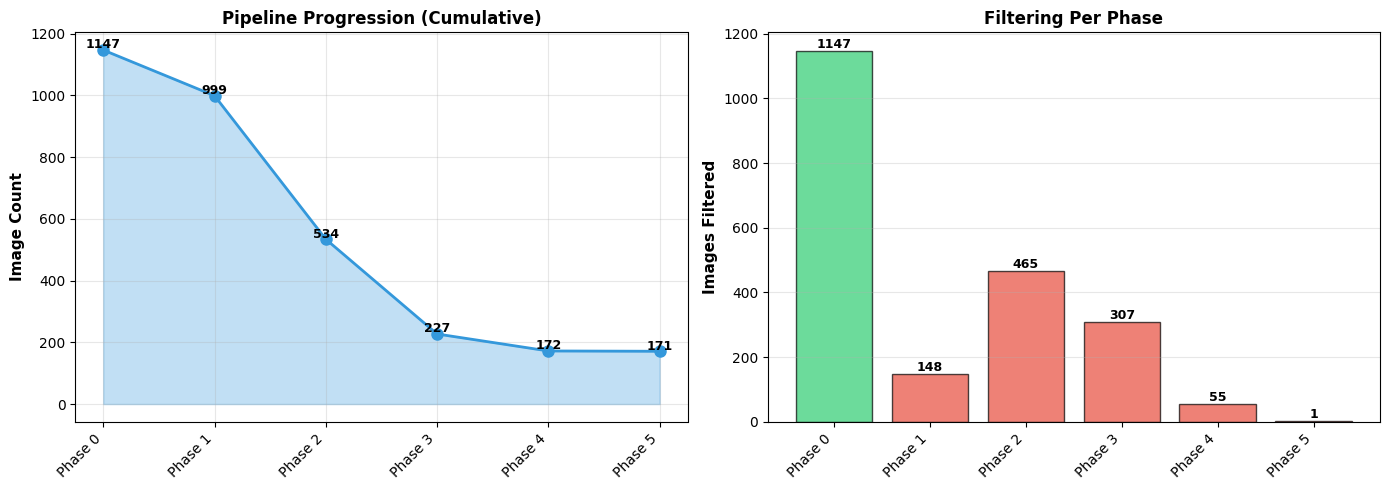


Retention rate: 14.9% of original images


In [6]:
# Create visualization
phases = list(phase_counts.keys())
counts = list(phase_counts.values())
filtered_counts = [counts[0]] + [counts[i-1] - counts[i] for i in range(1, len(counts))]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Line plot: Cumulative images
colors = ['#2ecc71' if c > 0 else '#e74c3c' for c in counts]
ax1.plot(range(len(phases)), counts, marker='o', linewidth=2, markersize=8, color='#3498db')
ax1.fill_between(range(len(phases)), counts, alpha=0.3, color='#3498db')
ax1.set_xticks(range(len(phases)))
ax1.set_xticklabels([p.split(':')[0] for p in phases], rotation=45, ha='right')
ax1.set_ylabel('Image Count', fontsize=11, fontweight='bold')
ax1.set_title('Pipeline Progression (Cumulative)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add values on line
for i, (x, y) in enumerate(zip(range(len(phases)), counts)):
    ax1.text(x, y + 5, str(y), ha='center', fontsize=9, fontweight='bold')

# Bar plot: Filtered per phase
bars = ax2.bar(range(len(phases)), filtered_counts, color=['#2ecc71'] + ['#e74c3c']*(len(phases)-1), alpha=0.7, edgecolor='black')
ax2.set_xticks(range(len(phases)))
ax2.set_xticklabels([p.split(':')[0] for p in phases], rotation=45, ha='right')
ax2.set_ylabel('Images Filtered', fontsize=11, fontweight='bold')
ax2.set_title('Filtering Per Phase', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add values on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nRetention rate: {final_retention:.1f}% of original images")

## 6. Summary

In [7]:
# Generate summary report
print("\n" + "="*70)
print("FINAL VALIDATION SUMMARY")
print("="*70)

summary = {
    'Original Images': original_count,
    'Duplicates Removed': phase_counts['Phase 0: Original'] - phase_counts['Phase 1: Cleaned'],
    'No Person Detected': phase_counts['Phase 1: Cleaned'] - phase_counts['Phase 2: Person Detected'],
    'Not Full-Body': phase_counts['Phase 2: Person Detected'] - phase_counts['Phase 3: Full-Body Valid'],
    'Age < 13 or No Face': phase_counts['Phase 3: Full-Body Valid'] - phase_counts['Phase 4: Age Filtered'],
    'Advertisements Detected': len(age_images) - len(final_images),
    'Final Clean Dataset': phase_counts['Phase 5: Final (No Ads)'],
    'Final Retention Rate (%)': f"{final_retention:.1f}%"
}

print("\n")
for key, value in summary.items():
    if isinstance(value, str):
        print(f"{key:.<40} {value:>15}")
    else:
        print(f"{key:.<40} {value:>15}")

print("\n" + "="*70)

# Validation status
print("\nVALIDATION STATUS:")
if checks_failed == 0:
    print("  ✅ All consistency checks PASSED")
    print("  ✅ Pipeline is working correctly")
else:
    print(f"  ⚠️  {checks_failed} consistency check(s) FAILED")
    print("  Review output above for details")

print("\n" + "="*70)


FINAL VALIDATION SUMMARY


Original Images.........................            1147
Duplicates Removed......................             148
No Person Detected......................             465
Not Full-Body...........................             307
Age < 13 or No Face.....................              55
Advertisements Detected.................               1
Final Clean Dataset.....................             171
Final Retention Rate (%)................           14.9%


VALIDATION STATUS:
  ✅ All consistency checks PASSED
  ✅ Pipeline is working correctly



## Notes
- Final output: data/final

## Manual Check (Final)
- Reviewed 1171 images in data/final
- FP: 6/171